# Deep-TICA - Alanine, multithermal

This is a brief tutorial that describes how to train the Deep-TICA CVs from a biased simulation. We use a OPES-multithermal simulation of alanine dipeptide as example, using all distances between heavy atoms as input descriptors.

This example is taken from: _Bonati, Piccini and Parrinello, Deep learning the slow modes for rare events sampling, PNAS (2021)_.

## Import

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlcvs.utils.io import load_dataframe
from mlcvs.tica import DeepTICA_CV

## Load data

We use the function `load_dataframe` from `mlcvs.utils` that takes a PLUMED COLVAR file and returns a pandas dataframe. First we load the COLVAR file containing the data about the OPES-multicanonical simulation and then the COLVAR_DRIVER which contains the input descriptors calculated along the trajectories (the second step can be avoided if they are already present in the first file).

We also discard the initial part of the simulation to put ourselves in the quasi-static regime, which is very quickly reached by OPES (it can be monitored by looking at the DELTAFS file for the multicanonical simulation).

---

| Parameter | Type | Description |
| :- | :- | :- |
| folder | str |files location |
| from_time | float | discard initial part of the trajectories [time units] |
| descriptor_filter | str |filter descriptors based on names |

In [3]:
#------------- PARAMETERS -------------
folder            = '../mlcvs/tests/data/ala2_multithermal/'
from_time         = 15000
descriptor_filter = 'd'
#--------------------------------------

# Load data
opes     =  load_dataframe(folder+"COLVAR", start=from_time)
features =  load_dataframe(folder+"COLVAR_DRIVER", start=from_time)

colvar = pd.concat([opes, features[[i for i in features.columns if (i not in opes.columns)]]], axis=1)

In [4]:
# Select descriptors 
X = colvar.filter(regex=descriptor_filter).values
n_input = X.shape[1]

print(X.shape)

(35001, 45)


## Compute weights for time rescaling

Here we extract the time $t$, the energy $E$ (needed for the multicanonical reweight [1]) and the bias $V$ from the COLVAR file. We then calculate the weights as:

\begin{cases}
    w = e^{\beta\ V + (\beta_0-\beta)\ E} & \text{if multicanonical}\\
    w = e^{\beta\ V}              & \text{otherwise}
\end{cases}

NB: note that if simulation temperature $\beta_0$ is equal to the reweighting one $\beta$ the multicanonical reweight coincides with the standard umbrella sampling-like case.

Once we have computed the weights, we rescale the time at step $k$ by using the instantaneus acceleration:

$$ dt'_k = w_k\ dt $$

and then compute the cumulative rescaled time:

$$ t'_k = \sum_{i=0} ^k dt'_i $$



[1] Invernizzi, Piaggi, and Parrinello. "Unified approach to enhanced sampling." _Physical Review X_ 10.4 (2020): 041034.


---

| Parameter | Type | Description |
| :- | :- | :- |
| multicanonical | bool | flag to determine if using a standard reweight (false) or a multicanonical one (true) |
| temp | float | reweighting temperature |
| temp0 | float | simulation temperature (only needed if multicanonical == True) |




In [5]:
#------------- PARAMETERS -------------
multicanonical    = True
temp              = 300.
temp0             = 300.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = colvar['time'].values # save time
ene = colvar['ene'].values.astype(np.float64) # store energy as long double
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweight += (beta0-beta)*ene

## Create dataset of time-lagged configurations

In order to train the Deep-TICA CVs we will need to compute the time-lagged covariance matrices in the rescaled time $t'$. The standard way is to look for configurations which are distant a lag-time $\tau$ in the time series. However, in the rescaled time the time-series is _exponentially_ unevenly spaced. Hence, a naive search will lead to severe numerical issue. To address this, we use the algorithm proposed in [2]. In a nutshell, this method assume that the observable $O(t'_k)$ have the same value from scaled time $t'_k$ to $t'_{k+1}$. This leads to weighting each pair of configurations based both on the rescaled time around $t'_k$ and $t'_k+\tau$ (see supp. information of [2] for details). All of this is done under the hood by the function `mlcvs.utils.data.find_time_lagged_configurations`. 

To generate the the training and validation set, we use the function `create_time_lagged_dataset` which searches for the pairs of configurations and the corresponding weight. This is divided in training and validation data, and fed to a `FastTensorDataloader` which allows for an efficient training of the model.

[2] Yang and Parrinello. "Refining collective coordinates and improving free energy representation in variational enhanced sampling." _Journal of chemical theory and computation_ 14.6 (2018): 2889-2894.

---

| Parameter | Type | Description |
| :- | :- | :- |
| lag_time | float | lag_time for the calculation of the covariance matrices [in rescaled time] |
| n_train | int | number of training configurations |
| n_valid | int | number of validation configurations |


In [14]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset

#------------- PARAMETERS -------------
lag_time = 0.1
n_train  = 25000 
n_valid  = 10000
#--------------------------------------

# create dataset
dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=logweight)

# split train - valid 
train_data = Subset(dataset, np.arange(2*n_train))
valid_data = Subset(dataset, np.arange(2*n_train,len(dataset)))

# create dataloaders 
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 69997
Training data:		 50000
Validation data:	 19997


## Training

Here we setup a few parameters and then train the Deep-TICA CVs. We first instantiate a object of the `DeepTICA_CV` class which defines the NN but also the loss function and a train loop. See class documentation for further details about parameters and methods.

---

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of TICA  |
| activ_type | string | Activation function (relu,tanh,elu,linear) |
| loss_type | string | Loss function operating on the TICA eigenvalues (sum2,sum,single)|
| n_eig | int | Number of eigenvalues to optimize (or if loss_type=single which one to select) |
| **Optimization** |
| lrate | float | Learning rate |
| l2_reg | float | L2 regularization |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| earlystop | bool | Whether to use early stopping based on validation loss |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| **Log** |
| log_every | int | How often print the train/valid loss during training |


In [15]:
#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = nodes[-1]

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_consecutive    = False

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=0)

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.,consecutive=es_consecutive, save_best_model=True, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

[Warninthe follig] Normalization: owing features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]], device='cuda:0')
Epoch Train Loss  Valid Loss  Eigenvalues             
10    -1.876      -1.880      0.972  0.962  
20    -1.904      -1.905      0.987  0.963  
30    -1.915      -1.915      0.993  0.964  
40    -1.920      -1.920      0.995  0.964  
50    -1.924      -1.923      0.996  0.966  
60    -1.927      -1.926      0.996  0.967  
70    -1.929      -1.928      0.996  0.968  
80    -1.931      -1.929      0.997  0.968  
90    -1.932      -1.930      0.997  0.969  
100   -1.934      -1.931      0.997  0.969  
110   -1.934      -1.932      0.997  0.970  
120   -1.935      -1.933      0.997  0.970  
130   -1.936      -1.933      0.997  0.970  
140   -1.937      -1.933      0.998  0.970  
150   -1.937      -1.934      0.998  0.970  
160   -1.938      -1.934      0.998  0.971  
I

In [16]:
## move the model back to cpu for convenience
model.to('cpu')

DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

In the next cells we analyze training and the resulting Deep-TICA CVs.

## Plot learning curve

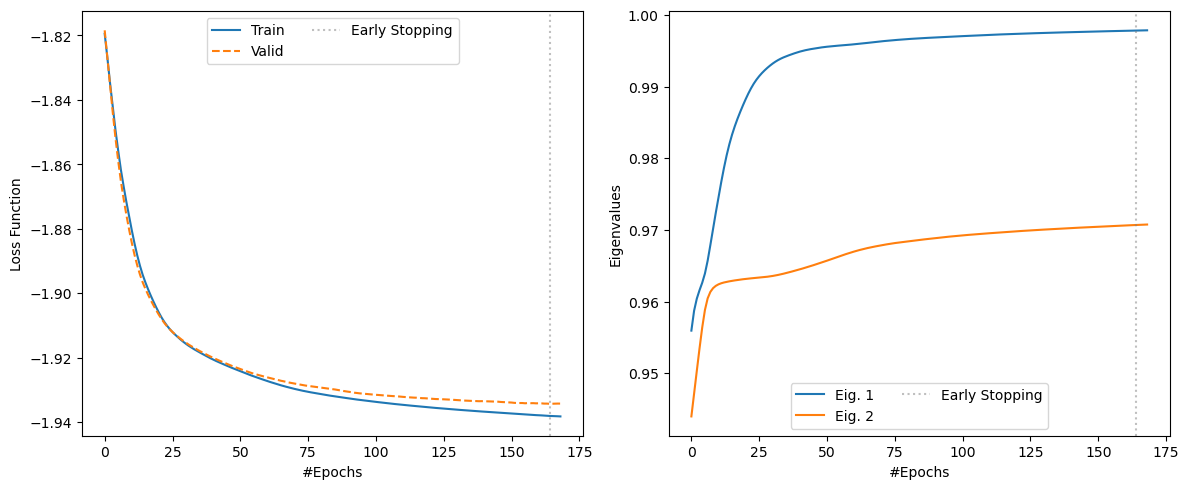

In [17]:
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=100)

loss_train = [x.cpu() for x in model.loss_train]
loss_valid = [x.cpu() for x in model.loss_valid]

# Loss function
ax = axs[0]
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

# Eigenvalues vs epoch
ax = axs[1]
with torch.no_grad():
    evals_train = np.asarray(torch.cat(model.evals_train).cpu())
for i in range(n_eig):
    ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
ax.set_ylabel('Eigenvalues')

# Common setup
for ax in axs:
    if model.earlystopping_.early_stop:
        ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
        ax.set_xlabel('#Epochs')
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()

## Plot CVs isolines in $\phi-\psi$ space

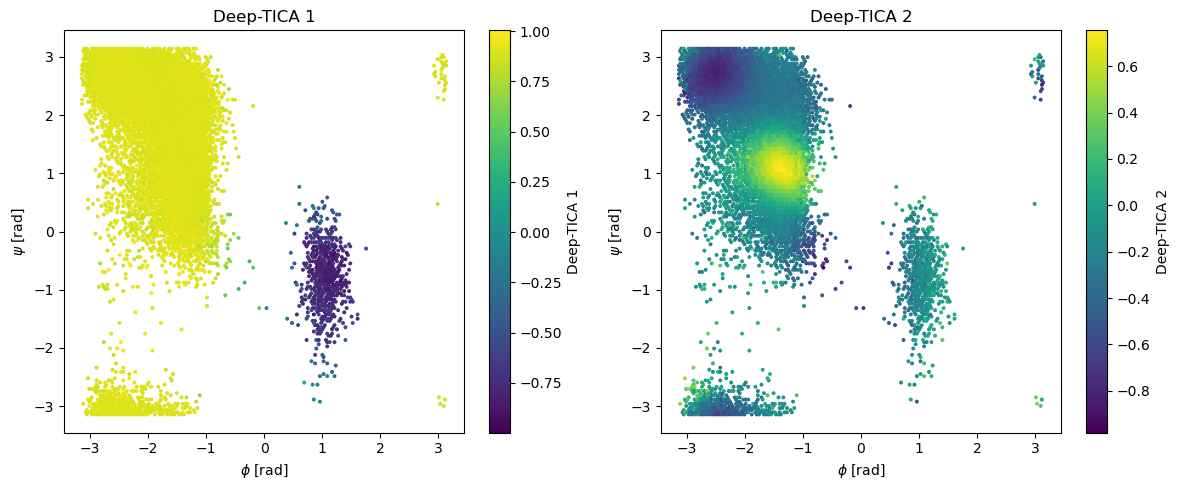

In [18]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150)#,cmap=cm_fessa)
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()